# Credit Risk Model and Scorecard with scorecardpy

## HMEQ Dataset

Dataset Content Extract (taken from Kaggle)
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable indicating whether an applicant eventually defaulted or was seriously delinquent. This adverse outcome occurred in 1,189 cases (20%). For each applicant, 12 input variables were recorded.

The data is originally taken from the Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS book website - https://www.bartbaesens.com/book/6/credit-risk-analytics.

A cleaner version of the data is on Kaggle - https://www.kaggle.com/akhil14shukla/loan-defaulter-prediction/data


**Variables definition**

1. BAD: Binary response variable
    - 1 = applicant defaulted on loan or seriously delinquent; 
    - 0 = applicant paid loan or customer is current on loan payments. This is the class column.
2. LOAN: Requested loan amount
3. MORTDUE: Amount due on existing mortgage
4. VALUE: Value of current property
5. REASON: 
    - DebtCon = debt consolidation(customer uses home equity loan to pay back high interest loans)
    - HomeImp = home improvement
6. JOB: Occupational categories
    - ProfExe
    - Mgr
    - Office
    - Self
    - Sales
    - Other
7. YOJ: Years at present job
8. DEROG: Number of major derogatory reports(issued for loans taken in the past when customer fails to keep up the contract or payback on time).
9. DELINQ: Number of delinquent credit lines
10. CLAGE: Age of oldest credit line in months
11. NINQ: Number of recent credit inquiries
12. CLNO: Number of credit lines
13. DEBTINC: Debt-to-income ratio in percent

## Import the necessary packages

In [1]:
#uncomment the pip command to install latest version(0.1.9.3) of scorecardpy from git
# !pip install git+https://github.com/ShichenXie/scorecardpy.git

#documentation for scorecardpy
#https://cloud.r-project.org/web/packages/scorecard/scorecard.pdf
# https://rdrr.io/cran/scorecard/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import the scorecardpy package
import scorecardpy as sc
import pprint

# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

**`scorecardpy` handles missing data by  grouping them into a 'missing' bin. We will use the version of data that was saved after dropping rows with several missing variables. For categorical variables, it computes the WOE per category and combines similar categories such that the IV is optimised. Hence we do not worry about encoding categorical data.**

## Data Exploration and Preparation

In [3]:
hmeq_data = pd.read_csv('hmeq_data.csv')

In [4]:
hmeq_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [5]:
hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [6]:
#rows, columns
hmeq_data.shape

(5960, 13)

In [7]:
#Quick way to also look at categorical columns. Check the number of unique values and most frequent value
hmeq_data.describe(include = 'all')

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5708,5681,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
unique,NaN,NaN,NaN,NaN,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,DebtCon,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,3928,2388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.199497,18607.969799,73760.817200,101776.048741,NaN,NaN,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,NaN,NaN,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,NaN,NaN,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,NaN,NaN,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,NaN,NaN,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141


In [8]:
#find the range of values for the numerical variables
#ranges varies quite abit
def describe_range(df):
    df1 = df.describe()
    df1.loc["range"] = df1.loc['max'] - df1.loc['min']
    return df1

describe_range(hmeq_data).loc["range"]


BAD             1.000000
LOAN        88800.000000
MORTDUE    397487.000000
VALUE      847909.000000
YOJ            41.000000
DEROG          10.000000
DELINQ         15.000000
CLAGE        1168.233561
NINQ           17.000000
CLNO           71.000000
DEBTINC       202.787649
Name: range, dtype: float64

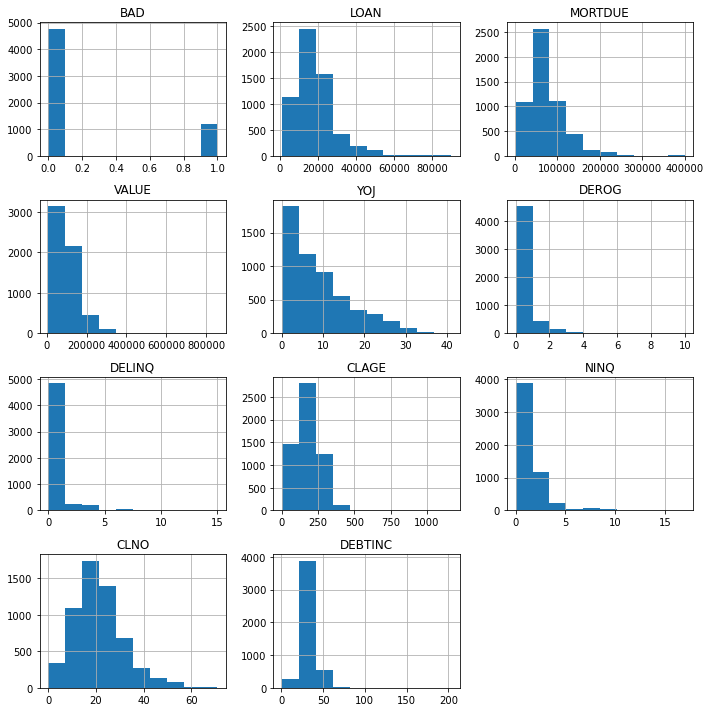

In [9]:
#single variable visualisation
hmeq_data.hist(figsize=(10,10))
plt.tight_layout()

BAD             0         1
REASON                     
DebtCon  0.810336  0.189664
HomeImp  0.777528  0.222472
<class 'pandas.core.frame.DataFrame'>
BAD             0         1
JOB                        
Mgr      0.766623  0.233377
Office   0.868143  0.131857
Other    0.768007  0.231993
ProfExe  0.833856  0.166144
Sales    0.651376  0.348624
Self     0.699482  0.300518
<class 'pandas.core.frame.DataFrame'>


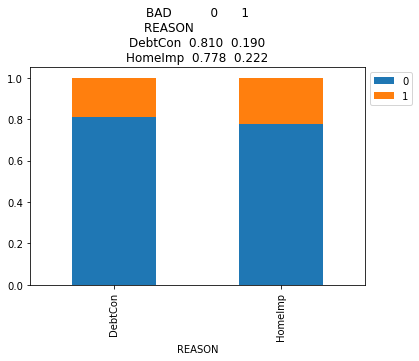

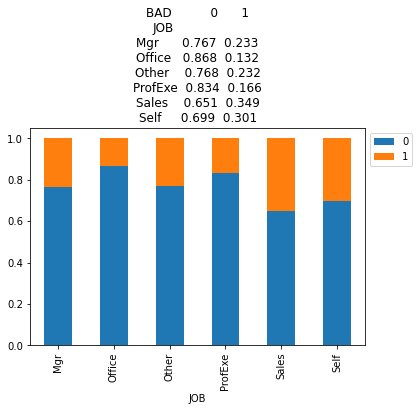

In [10]:
#note only groupby categorical variable

#Plot a percent stacked bar chart for bivariate analysis
df_REASONBivariate = hmeq_data.groupby('REASON')['BAD'].value_counts(normalize = True).unstack()
print(df_REASONBivariate)
print(type(df_REASONBivariate))

ax = df_REASONBivariate.plot(kind='bar', stacked='True', title = str(df_REASONBivariate.round(3)))
#place legend outside the chart
ax.legend(bbox_to_anchor=(1.0, 1.0))

#Plot a percent stacked bar chart for bivariate analysis
df_JOBBivariate = hmeq_data.groupby('JOB')['BAD'].value_counts(normalize = True).unstack()
print(df_JOBBivariate)
print(type(df_JOBBivariate))

ax = df_JOBBivariate.plot(kind='bar', stacked='True', title = str(df_JOBBivariate.round(3)))
#place legend outside the chart
ax.legend(bbox_to_anchor=(1.0, 1.0))


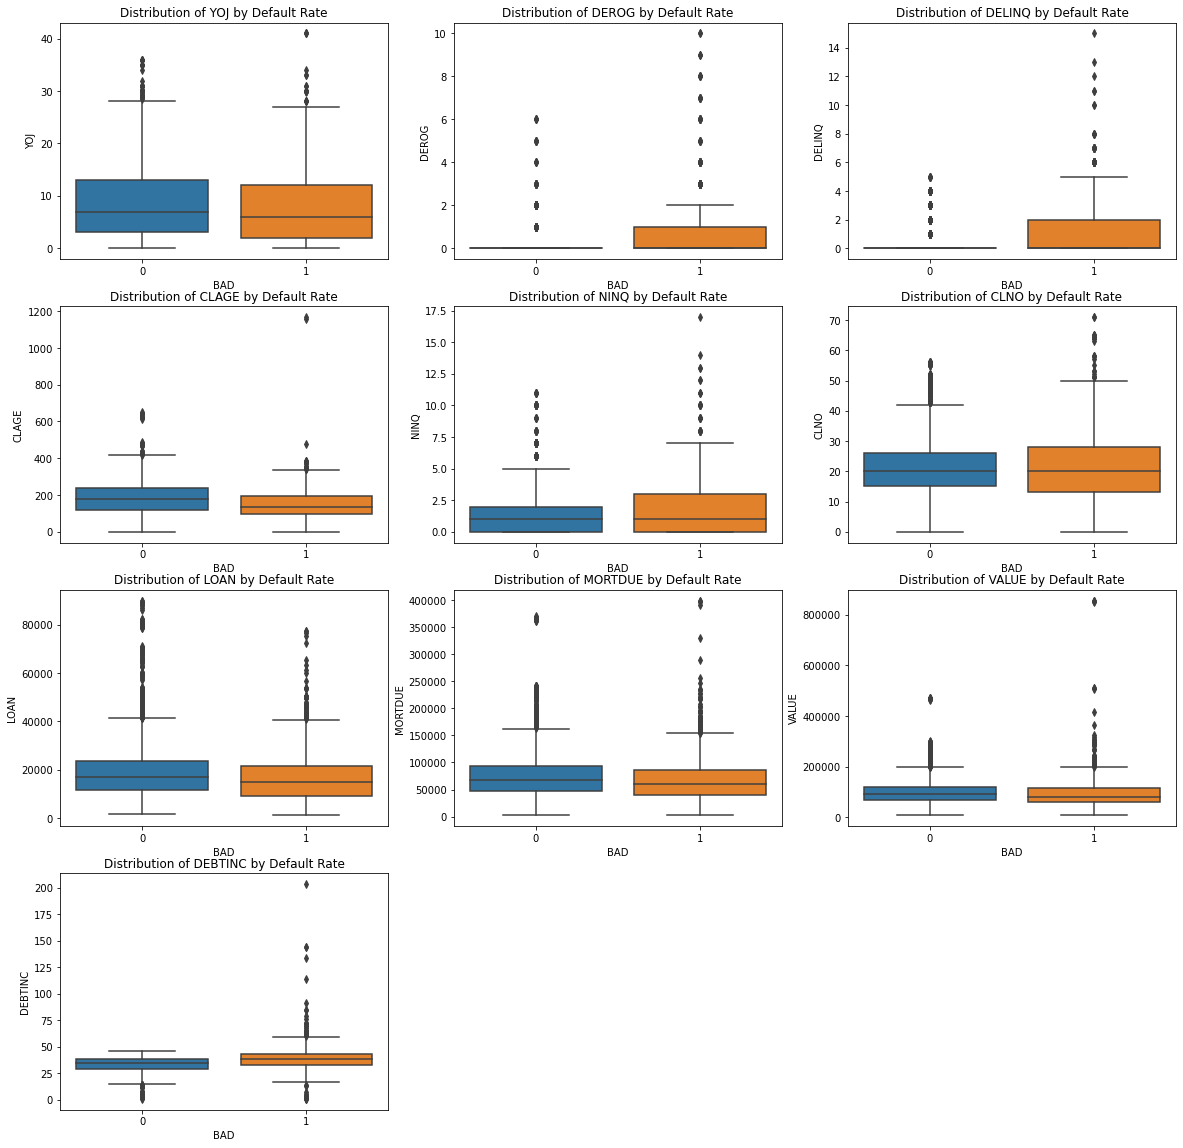

In [11]:
#bivariate visualisation
#where y is a continuous numerical variable and X is a categorical variable

fig, ax = plt.subplots(4,3 , figsize = (20,20))

sns.boxplot(y = hmeq_data["YOJ"], x=hmeq_data["BAD"], ax = ax[0,0]).set_title("Distribution of YOJ by Default Rate")
sns.boxplot(y= hmeq_data["DEROG"], x=hmeq_data["BAD"], ax = ax[0,1]).set_title("Distribution of DEROG by Default Rate")
sns.boxplot(y= hmeq_data["DELINQ"], x=hmeq_data["BAD"], ax = ax[0,2]).set_title("Distribution of DELINQ by Default Rate")
sns.boxplot(y= hmeq_data["CLAGE"], x=hmeq_data["BAD"], ax = ax[1,0]).set_title("Distribution of CLAGE by Default Rate")
sns.boxplot(y= hmeq_data["NINQ"], x=hmeq_data["BAD"], ax = ax[1,1]).set_title("Distribution of NINQ by Default Rate")
sns.boxplot(y= hmeq_data["CLNO"], x=hmeq_data["BAD"], ax = ax[1,2]).set_title("Distribution of CLNO by Default Rate")
sns.boxplot(y= hmeq_data["LOAN"], x=hmeq_data["BAD"], ax = ax[2,0]).set_title("Distribution of LOAN by Default Rate")
sns.boxplot(y= hmeq_data["MORTDUE"], x=hmeq_data["BAD"], ax = ax[2,1]).set_title("Distribution of MORTDUE by Default Rate")
sns.boxplot(y= hmeq_data["VALUE"], x=hmeq_data["BAD"], ax = ax[2,2]).set_title("Distribution of VALUE by Default Rate")
sns.boxplot(y= hmeq_data["DEBTINC"], x=hmeq_data["BAD"], ax = ax[3,0]).set_title("Distribution of DEBTINC by Default Rate")
#https://stackoverflow.com/questions/44980658/remove-the-extra-plot-in-the-matplotlib-subplot
ax[3,1].set_axis_off()
ax[3,2].set_axis_off()


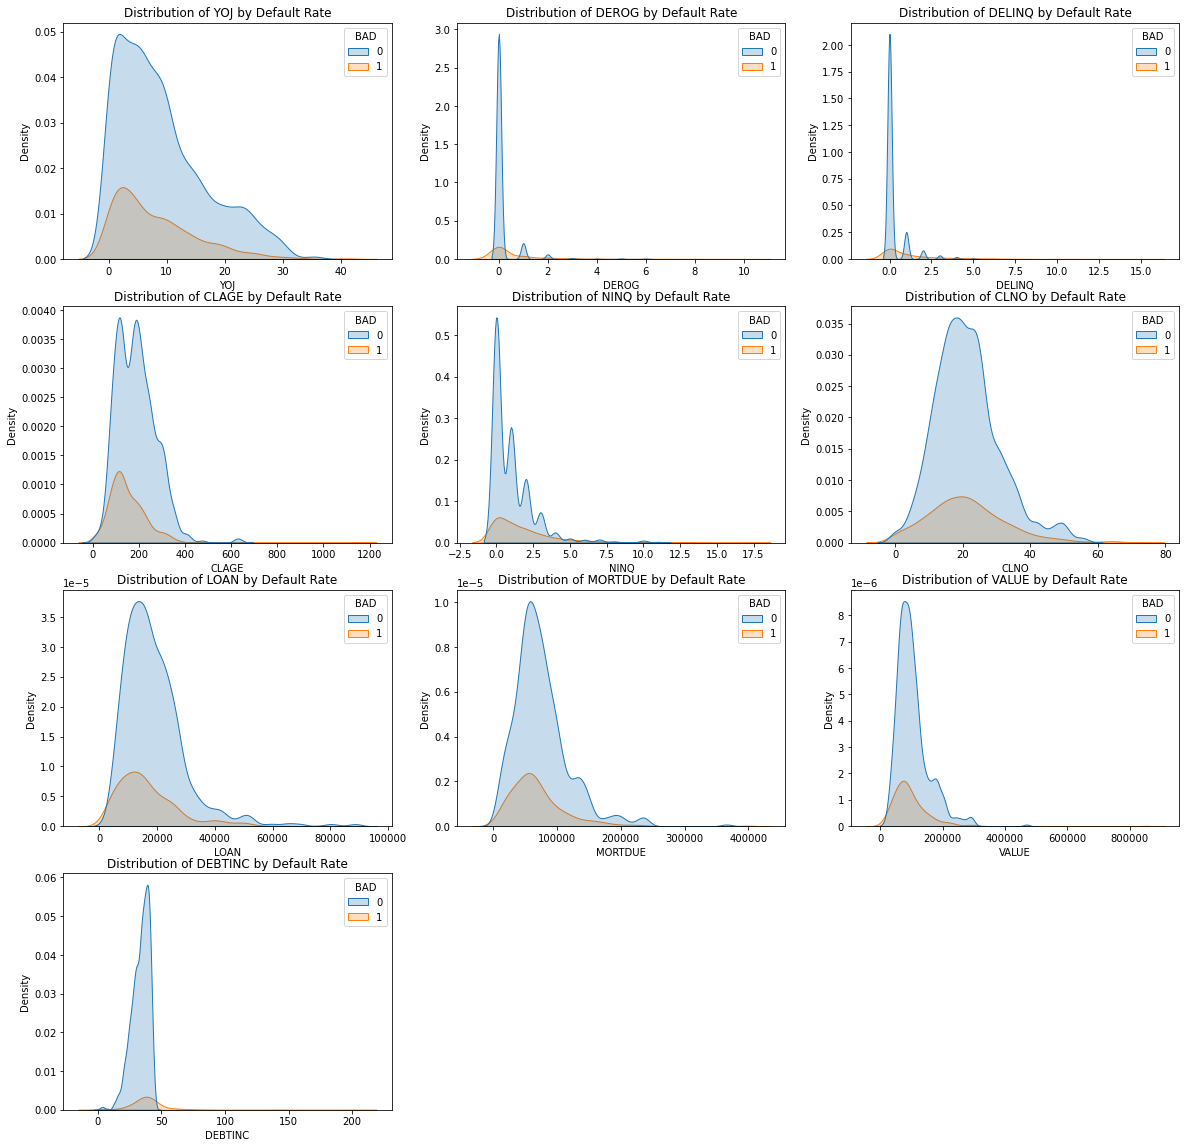

In [12]:
#bivariate visualisation-kde plots
#where y is a continuous numerical variable and X is a categorical variable
#this is similar to the histogram except you can visualise the distribution of the x variable

fig, ax = plt.subplots(4,3 , figsize = (20,20))

sns.kdeplot(data = hmeq_data, x="YOJ", hue="BAD", fill = True, ax = ax[0,0]).set_title("Distribution of YOJ by Default Rate")
sns.kdeplot(data = hmeq_data, x="DEROG", hue="BAD", fill = True, ax = ax[0,1]).set_title("Distribution of DEROG by Default Rate")
sns.kdeplot(data = hmeq_data, x="DELINQ", hue="BAD", fill = True, ax = ax[0,2]).set_title("Distribution of DELINQ by Default Rate")
sns.kdeplot(data = hmeq_data, x="CLAGE", hue="BAD", fill = True, ax = ax[1,0]).set_title("Distribution of CLAGE by Default Rate")
sns.kdeplot(data = hmeq_data, x="NINQ", hue="BAD", fill = True, ax = ax[1,1]).set_title("Distribution of NINQ by Default Rate")
sns.kdeplot(data = hmeq_data, x="CLNO", hue="BAD", fill = True, ax = ax[1,2]).set_title("Distribution of CLNO by Default Rate")
sns.kdeplot(data = hmeq_data, x="LOAN", hue="BAD", fill = True, ax = ax[2,0]).set_title("Distribution of LOAN by Default Rate")
sns.kdeplot(data = hmeq_data, x="MORTDUE", hue="BAD", fill = True, ax = ax[2,1]).set_title("Distribution of MORTDUE by Default Rate")
sns.kdeplot(data = hmeq_data, x="VALUE", hue="BAD", fill = True, ax = ax[2,2]).set_title("Distribution of VALUE by Default Rate")
sns.kdeplot(data = hmeq_data, x="DEBTINC", hue="BAD", fill = True, ax = ax[3,0]).set_title("Distribution of DEBTINC by Default Rate")
#https://stackoverflow.com/questions/44980658/remove-the-extra-plot-in-the-matplotlib-subplot
ax[3,1].set_axis_off()
ax[3,2].set_axis_off()



In [13]:
#The scorecardpy can create seperate bins for missing values. Hence keep the missing data as is.
hmeq_data.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [14]:
#no rows in the dataset which have missing values in all columns
hmeq_data.isnull().all().sum()

0

In [15]:
#NOTE WE ARE NOT DROPPING ANY MISSING VALUES (OR IMPUTE IT) IN THE DATASET AS IT CAN BE HANDLED BY SCORECARD.PY
#This does not drop any rows from the data. 'how = all' refers to dropping rows with all values missing,
#in our data BAD and LOAN have 0 missing values
# hmeq_data.dropna(how = 'all', inplace = True)

#instead drop using a threshold value. Retain rows which have atleast 10 non-null values
# hmeq_data.dropna(thresh= 10, inplace = True)


# hmeq_data['JOB'].fillna(value = 'Missing' , inplace= True)

**By definition of variables does imputing them sound valid ?**
- MORTDUE could be predicted based on all other inputs using regression techniques. Using mean or median here may not be the correct approach. A missing value could also be valid in this context (mortgage could have been paid off already)
- We may not have enough information to impute 'VALUE' column. However Loan amount, JOB, DEBTINC could be an indicator, we can check that from correlation.
- REASON - Evaluate if we can predict using Decision tree or by comparing the mean/median value of LOAN,within the category(compare between DebtCon and HomeImpr). Alternatively we could analyse the missing values bin as is.
- For all other variables, data may need to be collected from the client else consider dropping.
- **For most cases, we will label the missing data as 'Missing'. This group can be treated separately to study the effect of default.**

<AxesSubplot:>

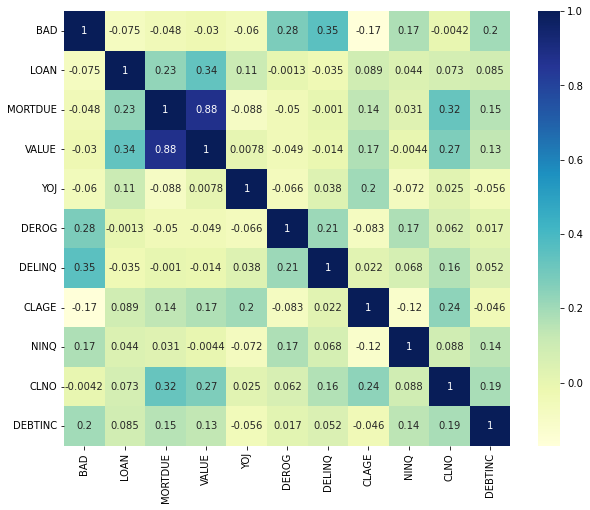

In [16]:
# Generate correlation maxtrix
cor = hmeq_data.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True,cmap="YlGnBu", ax=ax)

#High correlation between Value and Mortdue. Higher property values could mean they have higher mortgage loans and hence dues. 
#However the equity loan amount here is not correlated, maybe since these are revolving funds(credit lines) and the amounts taken do not imply any correlation.

In [17]:
#sorting the correlated pairs by strength of correlation
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr_rank=cor.abs().unstack().sort_values(ascending=False)

#remove correlation with itself (the same variable)
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr_rank[corr_rank!=1].head(15)

VALUE    MORTDUE    0.875666
MORTDUE  VALUE      0.875666
BAD      DELINQ     0.354107
DELINQ   BAD        0.354107
VALUE    LOAN       0.335393
LOAN     VALUE      0.335393
MORTDUE  CLNO       0.323631
CLNO     MORTDUE    0.323631
BAD      DEROG      0.276081
DEROG    BAD        0.276081
CLNO     VALUE      0.269149
VALUE    CLNO       0.269149
CLAGE    CLNO       0.237987
CLNO     CLAGE      0.237987
MORTDUE  LOAN       0.228595
dtype: float64

In [18]:
#use a copy of cleaned hmeq_data for credit risk model
hmeq_data_forsc = hmeq_data.copy()

In [19]:
#Drop MORTDUE, as it is highly correlated with Value
hmeq_data_forsc.drop(columns= 'MORTDUE', inplace= True)

## WOE Binning and Univariate Screening 

**What is Weight of Evidence?**

The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan.

The formula to calculate the weight of evidence for any feature is given by
![woe formula](https://4.bp.blogspot.com/-X1m0w40w0xg/V9V_7LS1AQI/AAAAAAAAFWc/f4bgPvE1In8Q13kGGBghp98MeWma8KgqACLcB/s320/woe.png)

The concept of WOE can also be understood in terms of events and non-events. It is calculated by taking the natural logarithm (log to base e) of division of % of non-events and % of events.
![woe formula 2](https://3.bp.blogspot.com/-eqZJpJZ4Kig/VPnZUBaP7II/AAAAAAAADkc/yeW8XVL35dA/s1600/weight%2Bof%2Bevidence.png)

**What is Information Value?**

Information Value (IV) is a measures of predictive power which is useful in feature selection and also assess the appropriateness of classing. <br>
It is a good practice to perform feature selection(select predictive variables) to determine if it is necessary to include all the features in the model, most times we will want to eliminate weak features as a simpler model is usually preferred.

The IV is calculated using the following formula :

![woe formula 2](https://2.bp.blogspot.com/-hkTX-LJoANY/VPnv5Wd3UoI/AAAAAAAADk4/SZFPuuecbkg/s1600/IV.png)

Here are the steps to calculate the WOE and IV as followed in the Lab: 
1. For a continuous variable, split data into 10 bins (or lesser depending on the distribution).
2. Calculate the number of events and non-events in each group (bin).
3. Calculate the % of events and % of non-events in each group.
4. Calculate WOE by taking natural log of division of % of non-events and % of events per bin.
5. Apply the IV formula to compute IV using the WOE values.

<font color = 'blue' size = 2>**Use the Pandas qcut API to perform binning or discretization of the variable**</font> <br>
https://pandas.pydata.org/docs/reference/api/pandas.qcut.html

**Generate WOE bins. By default the woebin() uses Tree based methods for binning. The bins generated from sc.woebin is a python dictionary object. <br>**

In [20]:
bins = sc.woebin(hmeq_data_forsc, y='BAD')
print(bins)

[INFO] creating woe binning ...
{'DELINQ':   variable         bin  count  count_distr  good  bad   badprob       woe  \
0   DELINQ     missing    580     0.097315   508   72  0.124138 -0.564372   
1   DELINQ  [-inf,1.0)   4179     0.701174  3596  583  0.139507 -0.429947   
2   DELINQ   [1.0,2.0)    654     0.109732   432  222  0.339450  0.723695   
3   DELINQ   [2.0,inf)    547     0.091779   235  312  0.570384  1.672861   

     bin_iv  total_iv   breaks  is_special_values  
0  0.025917  0.565325  missing               True  
1  0.113245  0.565325      1.0              False  
2  0.069594  0.565325      2.0              False  
3  0.356569  0.565325      inf              False  , 'NINQ':   variable         bin  count  count_distr  good  bad   badprob       woe  \
0     NINQ     missing    510     0.085570   435   75  0.147059 -0.368415   
1     NINQ  [-inf,1.0)   2531     0.424664  2135  396  0.156460 -0.295364   
2     NINQ   [1.0,2.0)   1339     0.224664  1085  254  0.189694 -0.0625

In [21]:
for variables , bindetails in bins.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

DELINQ  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DELINQ,missing,580,0.097315,508,72,0.124138,-0.564372,0.025917,0.565325,missing,True
1,DELINQ,"[-inf,1.0)",4179,0.701174,3596,583,0.139507,-0.429947,0.113245,0.565325,1.0,False
2,DELINQ,"[1.0,2.0)",654,0.109732,432,222,0.339450,0.723695,0.069594,0.565325,2.0,False
3,DELINQ,"[2.0,inf)",547,0.091779,235,312,0.570384,1.672861,0.356569,0.565325,inf,False


----------------------------------------------------------------------------------------------------
NINQ  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NINQ,missing,510,0.085570,435,75,0.147059,-0.368415,0.010352,0.170919,missing,True
1,NINQ,"[-inf,1.0)",2531,0.424664,2135,396,0.156460,-0.295364,0.033802,0.170919,1.0,False
2,NINQ,"[1.0,2.0)",1339,0.224664,1085,254,0.189694,-0.062558,0.000863,0.170919,2.0,False
3,NINQ,"[2.0,4.0)",1172,0.196644,884,288,0.245734,0.267947,0.015255,0.170919,4.0,False
4,NINQ,"[4.0,inf)",408,0.068456,232,176,0.431373,1.113190,0.110647,0.170919,inf,False


----------------------------------------------------------------------------------------------------
LOAN  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LOAN,"[-inf,6000.0)",304,0.051007,162,142,0.467105,1.257674,0.107497,0.167256,6000.0,False
1,LOAN,"[6000.0,8000.0)",342,0.057383,250,92,0.269006,0.389771,0.009735,0.167256,8000.0,False
2,LOAN,"[8000.0,16000.0)",2228,0.373826,1772,456,0.204668,0.032072,0.000388,0.167256,16000.0,False
3,LOAN,"[16000.0,38000.0)",2738,0.459396,2323,415,0.151570,-0.332893,0.045895,0.167256,38000.0,False
4,LOAN,"[38000.0,inf)",348,0.058389,264,84,0.241379,0.244311,0.003741,0.167256,inf,False


----------------------------------------------------------------------------------------------------
VALUE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,VALUE,missing,112,0.018792,7,105,0.937500,4.097494,0.355836,0.496947,missing,True
1,VALUE,"[-inf,40000.0)",319,0.053523,207,112,0.351097,0.775223,0.039389,0.496947,40000.0,False
2,VALUE,"[40000.0,50000.0)",305,0.051174,221,84,0.275410,0.422097,0.010268,0.496947,50000.0,False
3,VALUE,"[50000.0,90000.0)",2354,0.394966,1917,437,0.185641,-0.089140,0.003055,0.496947,90000.0,False
4,VALUE,"[90000.0,125000.0)",1548,0.259732,1338,210,0.135659,-0.462380,0.048007,0.496947,125000.0,False
5,VALUE,"[125000.0,170000.0)",677,0.113591,531,146,0.215657,0.098288,0.001130,0.496947,170000.0,False
6,VALUE,"[170000.0,200000.0)",314,0.052685,288,26,0.082803,-1.015421,0.039091,0.496947,200000.0,False
7,VALUE,"[200000.0,inf)",331,0.055537,262,69,0.208459,0.055205,0.000172,0.496947,inf,False


----------------------------------------------------------------------------------------------------
JOB  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,JOB,missing,279,0.046812,256,23,0.082437,-1.020240,0.035008,0.123026,missing,True
1,JOB,Office,948,0.159060,823,125,0.131857,-0.495199,0.033362,0.123026,Office,False
2,JOB,ProfExe,1276,0.214094,1064,212,0.166144,-0.223761,0.010005,0.123026,ProfExe,False
3,JOB,"Other%,%Mgr",3155,0.529362,2422,733,0.232330,0.194240,0.021140,0.123026,"Other%,%Mgr",False
4,JOB,"Self%,%Sales",302,0.050671,206,96,0.317881,0.625915,0.023511,0.123026,"Self%,%Sales",False


----------------------------------------------------------------------------------------------------
YOJ  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YOJ,missing,515,0.086409,450,65,0.126214,-0.545417,0.021627,0.081805,missing,True
1,YOJ,"[-inf,6.0)",2248,0.377181,1705,543,0.241548,0.245232,0.024356,0.081805,6.0,False
2,YOJ,"[6.0,8.0)",574,0.096309,487,87,0.151568,-0.332913,0.009623,0.081805,8.0,False
3,YOJ,"[8.0,10.0)",556,0.093289,453,103,0.185252,-0.091720,0.000763,0.081805,10.0,False
4,YOJ,"[10.0,21.0)",1510,0.253356,1189,321,0.212583,0.080017,0.001661,0.081805,21.0,False
5,YOJ,"[21.0,inf)",557,0.093456,487,70,0.125673,-0.550326,0.023775,0.081805,inf,False


----------------------------------------------------------------------------------------------------
REASON  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REASON,missing,252,0.042282,204,48,0.190476,-0.057476,0.000137,0.008618,missing,True
1,REASON,DebtCon,3928,0.659060,3183,745,0.189664,-0.062752,0.002546,0.008618,DebtCon,False
2,REASON,HomeImp,1780,0.298658,1384,396,0.222472,0.138124,0.005935,0.008618,HomeImp,False


----------------------------------------------------------------------------------------------------
CLNO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CLNO,missing,222,0.037248,169,53,0.238739,0.229837,0.002104,0.091189,missing,True
1,CLNO,"[-inf,10.0)",561,0.094128,383,178,0.317291,0.623192,0.043268,0.091189,10.0,False
2,CLNO,"[10.0,24.0)",3085,0.517617,2536,549,0.177958,-0.140802,0.009830,0.091189,24.0,False
3,CLNO,"[24.0,27.0)",687,0.115268,597,90,0.131004,-0.502664,0.024850,0.091189,27.0,False
4,CLNO,"[27.0,39.0)",1080,0.181208,849,231,0.213889,0.087802,0.001434,0.091189,39.0,False
5,CLNO,"[39.0,inf)",325,0.054530,237,88,0.270769,0.398720,0.009704,0.091189,inf,False


----------------------------------------------------------------------------------------------------
DEBTINC  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBTINC,missing,1267,0.212584,481,786,0.620363,1.880533,1.053554,1.888705,missing,True
1,DEBTINC,"[-inf,31.0)",1534,0.257383,1454,80,0.052151,-1.510604,0.358730,1.888705,31.0,False
2,DEBTINC,"[31.0,42.0)",2804,0.470470,2602,202,0.072040,-1.166325,0.437941,1.888705,42.0,False
3,DEBTINC,"[42.0,inf)",355,0.059564,234,121,0.340845,0.729913,0.038481,1.888705,inf,False


----------------------------------------------------------------------------------------------------
DEROG  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEROG,missing,708,0.118792,621,87,0.122881,-0.575980,0.032825,0.347189,missing,True
1,DEROG,"[-inf,1.0)",4527,0.759564,3773,754,0.166556,-0.220790,0.034592,0.347189,1.0,False
2,DEROG,"[1.0,inf)",725,0.121644,377,348,0.480000,1.309401,0.279772,0.347189,inf,False


----------------------------------------------------------------------------------------------------
CLAGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CLAGE,missing,308,0.051678,230,78,0.253247,0.308073,0.005358,0.240081,missing,True
1,CLAGE,"[-inf,70.0)",302,0.050671,184,118,0.390728,0.945192,0.057351,0.240081,70.0,False
2,CLAGE,"[70.0,150.0)",2061,0.345805,1525,536,0.260068,0.343828,0.045096,0.240081,150.0,False
3,CLAGE,"[150.0,170.0)",373,0.062584,298,75,0.201072,0.009838,0.000006,0.240081,170.0,False
4,CLAGE,"[170.0,240.0)",1654,0.277517,1397,257,0.155381,-0.303563,0.023272,0.240081,240.0,False
5,CLAGE,"[240.0,inf)",1262,0.211745,1137,125,0.099049,-0.818391,0.108997,0.240081,inf,False


----------------------------------------------------------------------------------------------------


{'DELINQ': <Figure size 432x288 with 2 Axes>,
 'NINQ': <Figure size 432x288 with 2 Axes>,
 'LOAN': <Figure size 432x288 with 2 Axes>,
 'VALUE': <Figure size 432x288 with 2 Axes>,
 'JOB': <Figure size 432x288 with 2 Axes>,
 'YOJ': <Figure size 432x288 with 2 Axes>,
 'REASON': <Figure size 432x288 with 2 Axes>,
 'CLNO': <Figure size 432x288 with 2 Axes>,
 'DEBTINC': <Figure size 432x288 with 2 Axes>,
 'DEROG': <Figure size 432x288 with 2 Axes>,
 'CLAGE': <Figure size 432x288 with 2 Axes>}

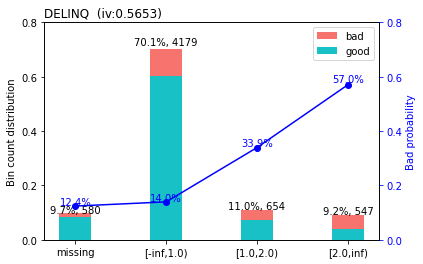

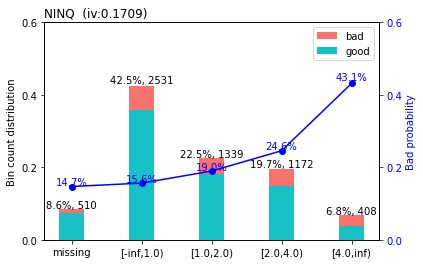

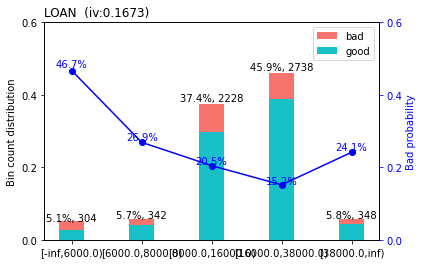

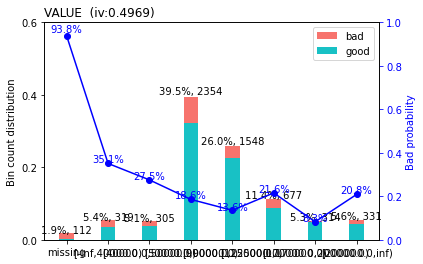

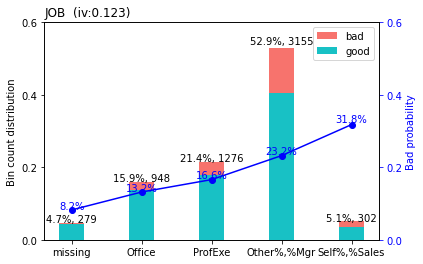

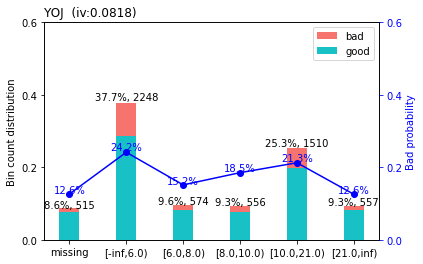

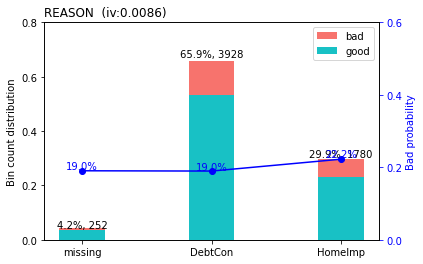

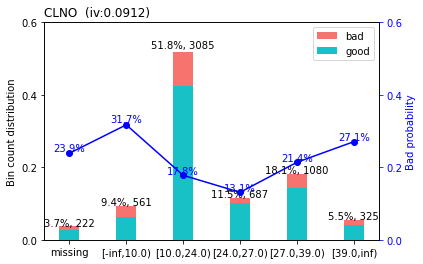

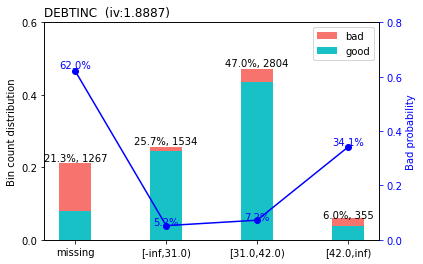

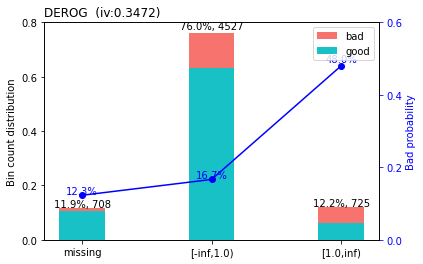

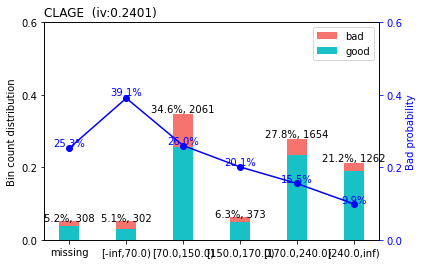

In [22]:
# Plot the bins
sc.woebin_plot(bins)



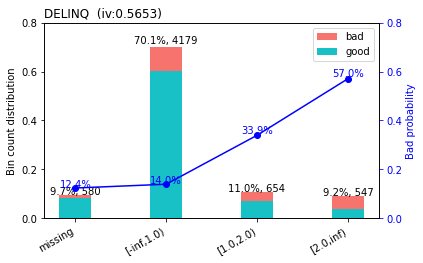

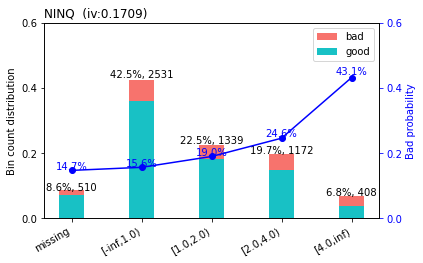

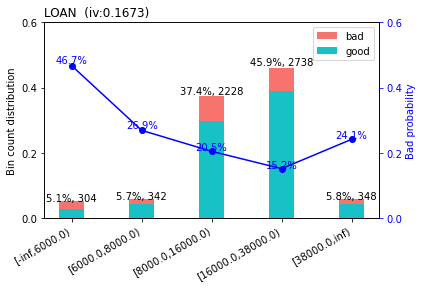

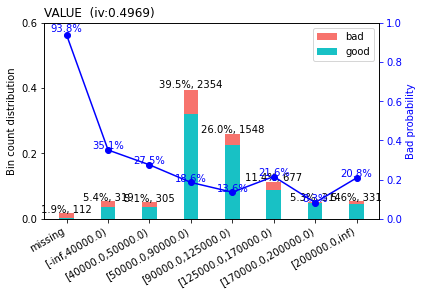

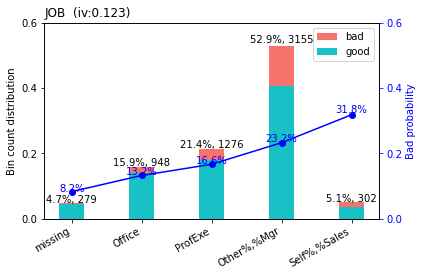

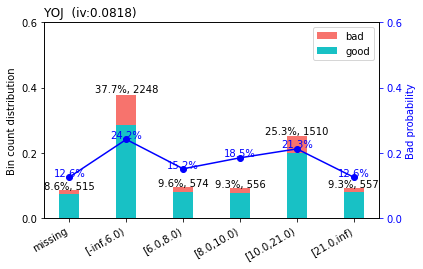

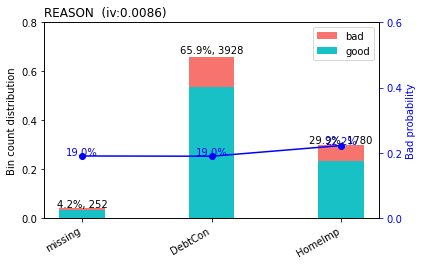

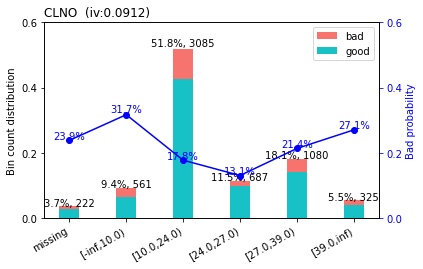

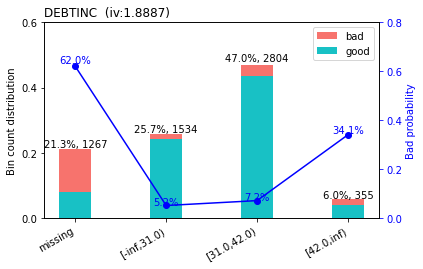

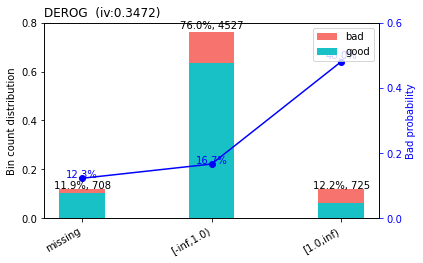

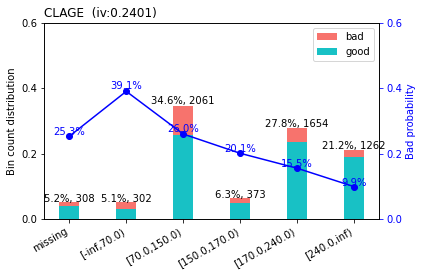

In [23]:
#extracted directly from the source code and added line 55 from https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
#to enable auto-alignment of the x labels in the plot such that overlapping would not occur. 
def plot_bin(binx, title, show_iv):
    '''
    plot binning of one variable
    
    Params
    ------
    binx:
    title:
    show_iv:
    
    Returns
    ------
    matplotlib fig object
    '''
    # y_right_max
    y_right_max = np.ceil(binx['badprob'].max()*10)
    if y_right_max % 2 == 1: y_right_max=y_right_max+1
    if y_right_max - binx['badprob'].max()*10 <= 0.3: y_right_max = y_right_max+2
    y_right_max = y_right_max/10
    if y_right_max>1 or y_right_max<=0 or y_right_max is np.nan or y_right_max is None: y_right_max=1
    ## y_left_max
    y_left_max = np.ceil(binx['count_distr'].max()*10)/10
    if y_left_max>1 or y_left_max<=0 or y_left_max is np.nan or y_left_max is None: y_left_max=1
    # title
    title_string = binx.loc[0,'variable']+"  (iv:"+str(round(binx.loc[0,'total_iv'],4))+")" if show_iv else binx.loc[0,'variable']
    title_string = title+'-'+title_string if title is not None else title_string
    # param
    ind = np.arange(len(binx.index))    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence
    ###### plot ###### 
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    # ax1
    p1 = ax1.bar(ind, binx['good_distr'], width, color=(24/254, 192/254, 196/254))
    p2 = ax1.bar(ind, binx['bad_distr'], width, bottom=binx['good_distr'], color=(246/254, 115/254, 109/254))
    for i in ind:
        ax1.text(i, binx.loc[i,'count_distr']*1.02, str(round(binx.loc[i,'count_distr']*100,1))+'%, '+str(binx.loc[i,'count']), ha='center')
    # ax2
    ax2.plot(ind, binx['badprob'], marker='o', color='blue')
    for i in ind:
        ax2.text(i, binx.loc[i,'badprob']*1.02, str(round(binx.loc[i,'badprob']*100,1))+'%', color='blue', ha='center')
    # settings
    ax1.set_ylabel('Bin count distribution')
    ax2.set_ylabel('Bad probability', color='blue')
    ax1.set_yticks(np.arange(0, y_left_max+0.2, 0.2))
    ax2.set_yticks(np.arange(0, y_right_max+0.2, 0.2))
    ax2.tick_params(axis='y', colors='blue')
    plt.xticks(ind, binx['bin'])
    plt.title(title_string, loc='left')
    plt.legend((p2[0], p1[0]), ('bad', 'good'), loc='upper right')
    # show plot 
    # plt.show()
    #https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
    fig.autofmt_xdate()
    return fig

for variables , bindetails in bins.items():
    bindetails['good_distr'] = bindetails['good']/sum(bindetails['count'])
    bindetails['bad_distr'] = bindetails['bad']/sum(bindetails['count'])
    plot_bin(bindetails,title=None,show_iv=True)

**Possible observations/hypothesis from binning**
 - DEROG - Trend is logical, higher DEROG values means higher Bad/default probability.
 - REASON - Trend does not say much. We will consider dropping this variable as it has very low IV. 
 - DEBTINC - The missing bin has high BAD rate. If we ignore the missing bin, we see that the trend is increasing. Additionally we may try to re-bin the data points between the 2nd and 3rd bin such that we see a clearer increasing trend. However, IV value is suspiciously high, we will consider dropping.
 - LOAN - Trend does not seem logical but is consistent (higher loan amounts should lead to higher Bad/default probability),however if we are seeing a decreasing trend instead of increasing trend. A reason for this could be due to loan applications with higher loan amounts are subjected to stricter checks to ensure that the risk of default is lower for higher loan amounts.
 - JOB - Trend looks fine and logical. (job occupation like office and ProfExe have more stable salary as compared to those in sales, whose salary are largely dependent on sales commissions.)
 - CLNO - The bins make logical sense. We can interpret it as, those with fewer credit lines are mostly defaulters and hence don't get credit and the ones with high credit lines are not able to repay.
 - DELINQ - Trend looks fine and logical. Even though IV is very high, we will keep this variable due to business reasons. 
 - CLAGE - Trend looks fine and logical (as the duration of the oldest credit line held by the applicant increases, this indicates greater stability in the finances of the applicant, thus the probability of Bad/default decreases). Except for the missing bin, the trend is decreasing.
 - YOJ - Trend does not say much.
 - NINQ - Trend looks fine and logical.
 - VALUE -  Trend looks fine and logical. The higher the value of the property the applicant currently owns, the lower the probability of Bad/default. We can use as it is in the credit model or verify the data to see if the 3rd last bin and the last bin can be reallocated to see the decreasing trend.

Note: In the above chart generated from scorecardPy we look at the bad probability, it should be made monotonous with bin adjustments, unless there are exception points of trend reversal. Yes this is analogous to using WOE. ( looking at the WOE values in the plot when establishing the monotonic trend. values for probability of bads corresponds to that of the WOE values)
)

FYI, we could also set the arguments to plot the WOE values instead.
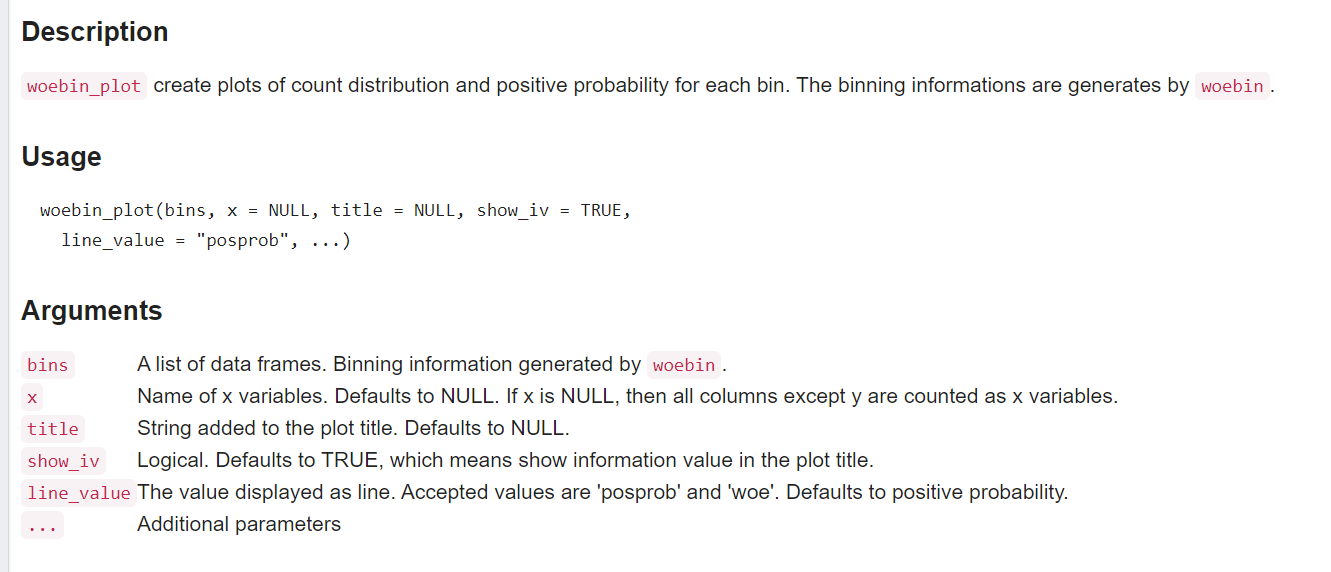

**DROP Low IV variables**

**Interpreting IV**

| Information Value | Variable Predictiveness |
| --- | --- |
| Less than 0.02 | Not useful for prediction |
| 0.02 to 0.1 | Weak predictive Power |
| 0.1 to 0.3 | Medium predictive Power |
| 0.3 to 0.5 | Strong predictive Power |
| >0.5 | Suspicious Predictive Power |

1. The following features are not useful/have weak predictive power towards predicting a potential default, based on their IV values
    - REASON is not useful for prediction 
    - While CLNO and YOJ have weak predictive power
 
2. The following features have suspiciously high IV value
   - DEBTINC (IV=1.90)
   - DELINQ (IV=0.57)



**Data preparation based on observations from WOE linear trend and IV** <br>

As a first step we could create a model with the default binning and keep all variables and see the model performance. However we have identified bin adjustments for LOAN, DEBTINC and VALUE variables and variables with very low IV and suspiciously high IV to be REASON and DEBTINC respectively. We shall incorporate these into data preparation before modeling.<br>

In [24]:
#add your code here
hmeq_data_forsc.drop(columns=["REASON","DEBTINC"],inplace=True)

In [25]:
#updated columns that we will consider
hmeq_data_forsc.columns

Index(['BAD', 'LOAN', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO'],
      dtype='object')

**Bin adjustments**

In [26]:
#define bin adjustments and do the re-binning

#adjustments for LOAN & VALUE 
breaks_adj = {'LOAN' : [3000, 6000,9000,12000],'VALUE':[40000,60000,100000,140000,165000,180000]}
bins2 = sc.woebin(hmeq_data_forsc, y='BAD',breaks_list=breaks_adj)

[INFO] creating woe binning ...


{'DELINQ': <Figure size 432x288 with 2 Axes>,
 'NINQ': <Figure size 432x288 with 2 Axes>,
 'LOAN': <Figure size 432x288 with 2 Axes>,
 'VALUE': <Figure size 432x288 with 2 Axes>,
 'JOB': <Figure size 432x288 with 2 Axes>,
 'YOJ': <Figure size 432x288 with 2 Axes>,
 'CLNO': <Figure size 432x288 with 2 Axes>,
 'DEROG': <Figure size 432x288 with 2 Axes>,
 'CLAGE': <Figure size 432x288 with 2 Axes>}

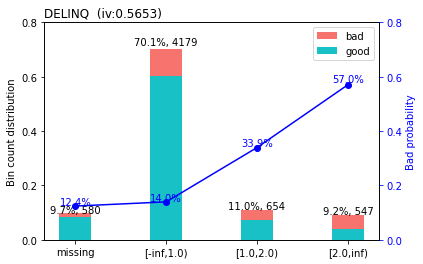

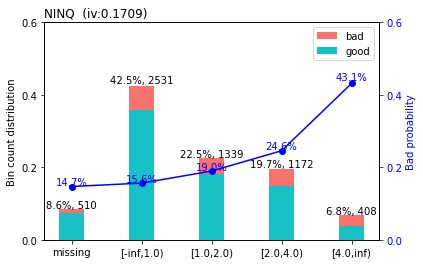

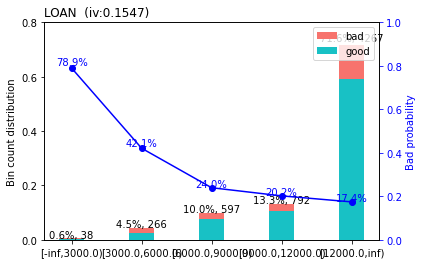

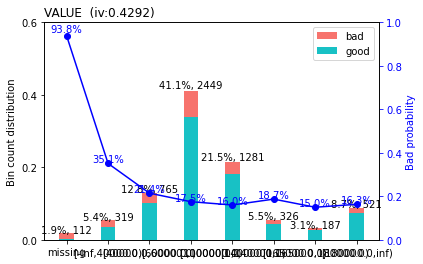

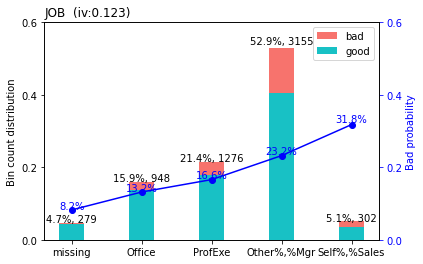

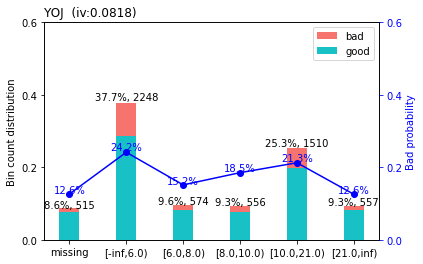

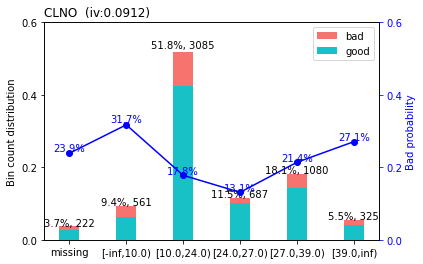

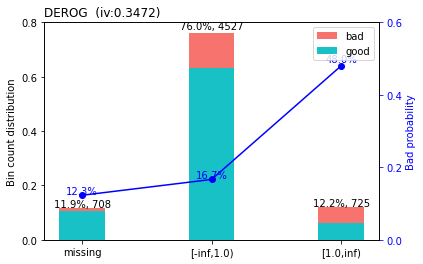

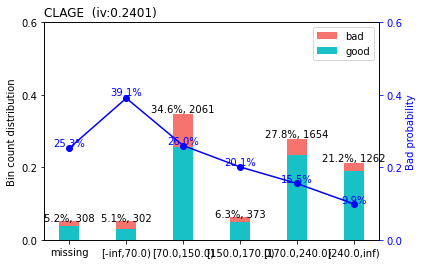

In [27]:
# Plot the bins

sc.woebin_plot(bins2)

## Training Logistic Regression model  and evaluating the performance of the model

**Prepare training and test data and convert to WOE values**

In [28]:
# Split data into 70% train and 30% test
train, test = sc.split_df(hmeq_data_forsc, 'BAD', ratio=0.7).values()
print(train.shape)
print(test.shape)

(4172, 10)
(1788, 10)


In [29]:
# Prepare a dataset with the WOE values for Logistic Regression training. woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train, bins2)
test_woe = sc.woebin_ply(test, bins2)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,BAD,DELINQ_woe,NINQ_woe,LOAN_woe,VALUE_woe,JOB_woe,YOJ_woe,CLNO_woe,DEROG_woe,CLAGE_woe
0,1,-0.429947,-0.062558,2.711199,0.775223,0.194240,0.080017,0.623192,-0.22079,0.343828
1,1,1.672861,-0.295364,2.711199,-0.159953,0.194240,-0.332913,-0.140802,-0.22079,0.343828
3,1,-0.564372,-0.368415,2.711199,4.097494,-1.020240,-0.545417,0.229837,-0.57598,0.308073
4,0,-0.429947,-0.295364,2.711199,-0.268552,-0.495199,0.245232,-0.140802,-0.22079,0.343828
5,1,-0.429947,-0.062558,2.711199,0.090715,0.194240,-0.091720,0.623192,-0.22079,0.343828
...,...,...,...,...,...,...,...,...,...,...
5951,0,-0.429947,-0.295364,-0.165584,-0.159953,0.194240,0.080017,-0.140802,-0.22079,-0.303563
5952,0,-0.429947,-0.295364,-0.165584,-0.159953,0.194240,0.080017,-0.140802,-0.22079,-0.303563
5955,0,-0.429947,-0.295364,-0.165584,-0.159953,0.194240,0.080017,-0.140802,-0.22079,-0.303563
5957,0,-0.429947,-0.295364,-0.165584,-0.159953,0.194240,0.080017,-0.140802,-0.22079,-0.303563


**Training the Logistic Regression model**

In [30]:
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'BAD']
X_train = train_woe.loc[:,train_woe.columns != 'BAD']
y_test = test_woe.loc[:,'BAD']
X_test = test_woe.loc[:,train_woe.columns != 'BAD']

#create a logistic regression model object
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[1.04244951 0.82075291 0.87792375 0.94571576 0.96299764 0.72560472
  0.89693601 0.6538482  0.84797713]]
[-1.40737046]


**Evaluate the performance of logistic regression model with KS and ROC**

Generate the K-S statistic and AUC for the model using the scorecardpy methods. Kolmogorov-Smirnov chart measures performance of classification models. ROC curve is a measures the performance of classifier at various threshold settings.

K-S statistic scores ranges from 0 to 1, where a good KS score would be a high value nearing 1. AUC-ROC score ranges from 0.5 to 1, where a good AUC-ROC score would be a high value nearing 1. 

C:\Users\acer\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\Users\acer\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


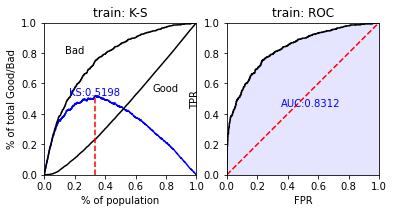

C:\Users\acer\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\Users\acer\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


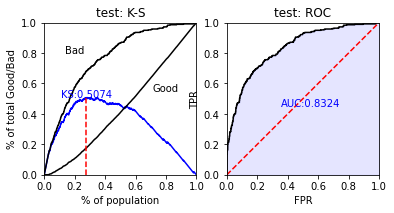

In [31]:
# Evaluate the performance of the Logistic Regression
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [32]:
# Generate model predictions on test data. Print Evaluation metrics of the model
y_pred = lr.predict(X_test)

print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))


              precision    recall  f1-score   support

           0       0.96      0.86      0.90      1601
           1       0.36      0.68      0.47       187

    accuracy                           0.84      1788
   macro avg       0.66      0.77      0.69      1788
weighted avg       0.90      0.84      0.86      1788

[[1371  230]
 [  60  127]]


**The model is not as good in predicting defaults, as compared to non-defaults, this could be due to the fact that the dataset sample we used is imbalanced and contains largely non-defaults outcomes. We can try retraining the model after doing some resampling to fix the fix the imbalanced class of default/non-default**

The AUC-ROC score for the model is good at 0.8 however the K-S score is only average at 0.5.

In [33]:
#occurrence of default events in the train set is around 20%, greatly lower than that of non-default events (80%)
y_train.value_counts(normalize = True)

0    0.800575
1    0.199425
Name: BAD, dtype: float64

## Generate the scorecard based on results from woebin and Logistic regression model

In [34]:
#generate a card from the model and bins. The scores will be based on probability of default from the model
#default target point is 600, default target odds is 1:19, pdo is 50. 
card = sc.scorecard(bins2, lr, X_train.columns)

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)


In [35]:
test_score

,score
2,272.0
8,201.0
12,323.0
19,403.0
22,271.0
...,...
5942,664.0
5953,580.0
5954,494.0
5956,580.0


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

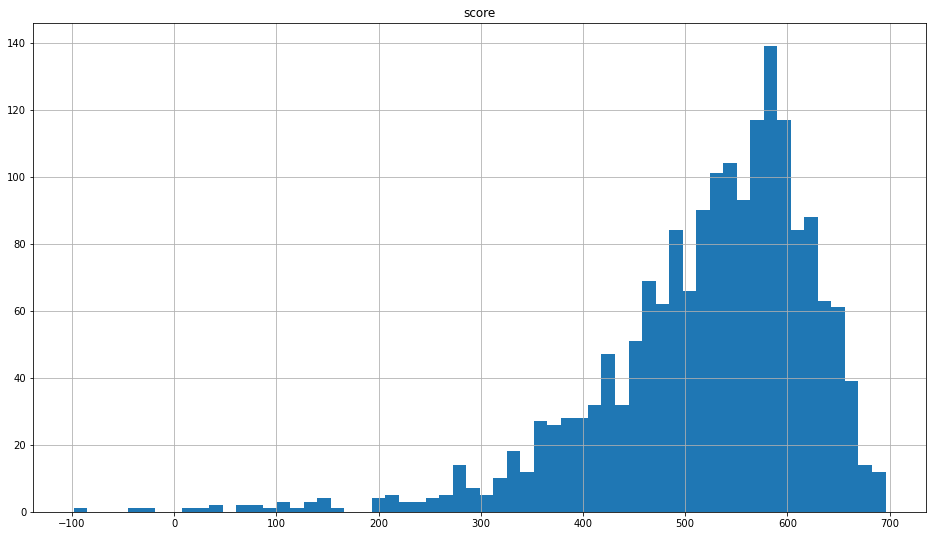

In [36]:
#distribution of scores on test data
test_score.hist(figsize=(16,9),bins=60)

**Now let us take a look at our scorecard. A credit score less than 485 will be below the neutral score**

The neutral score is where the WOE is 0 and where the odds of goods:bads is 1:1. A credit score score less than 485 would signify a greater likelihood of default.

In [37]:
pprint.pprint(card)

{'CLAGE':    variable            bin  points
42    CLAGE        missing   -19.0
43    CLAGE    [-inf,70.0)   -58.0
44    CLAGE   [70.0,150.0)   -21.0
45    CLAGE  [150.0,170.0)    -1.0
46    CLAGE  [170.0,240.0)    19.0
47    CLAGE    [240.0,inf)    50.0,
 'CLNO':    variable          bin  points
33     CLNO      missing   -15.0
34     CLNO  [-inf,10.0)   -40.0
35     CLNO  [10.0,24.0)     9.0
36     CLNO  [24.0,27.0)    33.0
37     CLNO  [27.0,39.0)    -6.0
38     CLNO   [39.0,inf)   -26.0,
 'DELINQ':   variable         bin  points
0   DELINQ     missing    42.0
1   DELINQ  [-inf,1.0)    32.0
2   DELINQ   [1.0,2.0)   -54.0
3   DELINQ   [2.0,inf)  -126.0,
 'DEROG':    variable         bin  points
39    DEROG     missing    27.0
40    DEROG  [-inf,1.0)    10.0
41    DEROG   [1.0,inf)   -62.0,
 'JOB':    variable           bin  points
22      JOB       missing    71.0
23      JOB        Office    34.0
24      JOB       ProfExe    16.0
25      JOB   Other%,%Mgr   -13.0
26      JOB  Self%,

**Scorecard with base points adjusted to 0**

In [38]:
card = sc.scorecard(bins2, lr, X_train.columns, basepoints_eq0= True)
pprint.pprint(card)

{'CLAGE':    variable            bin  points
42    CLAGE        missing    36.0
43    CLAGE    [-inf,70.0)    -3.0
44    CLAGE   [70.0,150.0)    33.0
45    CLAGE  [150.0,170.0)    54.0
46    CLAGE  [170.0,240.0)    73.0
47    CLAGE    [240.0,inf)   104.0,
 'CLNO':    variable          bin  points
33     CLNO      missing    39.0
34     CLNO  [-inf,10.0)    14.0
35     CLNO  [10.0,24.0)    63.0
36     CLNO  [24.0,27.0)    87.0
37     CLNO  [27.0,39.0)    49.0
38     CLNO   [39.0,inf)    29.0,
 'DELINQ':   variable         bin  points
0   DELINQ     missing    97.0
1   DELINQ  [-inf,1.0)    87.0
2   DELINQ   [1.0,2.0)    -0.0
3   DELINQ   [2.0,inf)   -71.0,
 'DEROG':    variable         bin  points
39    DEROG     missing    82.0
40    DEROG  [-inf,1.0)    65.0
41    DEROG   [1.0,inf)    -7.0,
 'JOB':    variable           bin  points
22      JOB       missing   125.0
23      JOB        Office    89.0
24      JOB       ProfExe    70.0
25      JOB   Other%,%Mgr    41.0
26      JOB  Self%,

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

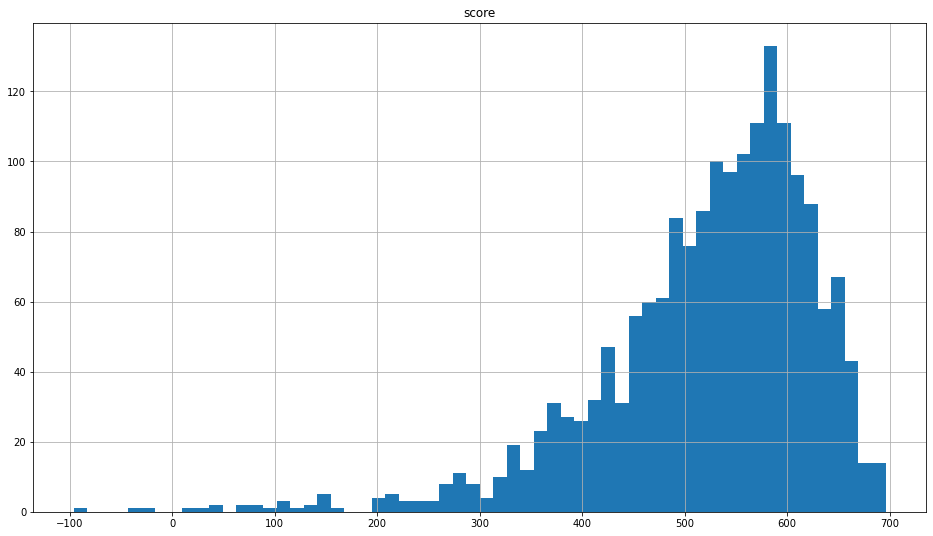

In [39]:
# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)
test_score.hist(figsize=(16,9),bins=60)

## Monitoring the long-term performance of scorecard model

**The metric, Population Stability Index (PSI) will be used. It measures the difference between the sample used for model development and a current sample and helps to detect if the scorecard model is affected by changes such as change in population being measured, change in economic environment and change in product behaviour (e.g interest rates)**

**Interpreting PSI**

| PSI Value | Interpretation |
| --- | --- |
| Less than 0.10 | model is still good and updated with the current sample |
| 0.10 to 0.25 | There is minor change between sample used and current sample, the current sample should be investigated |
| >0.25 | A new model should be developed using a more recent sample |

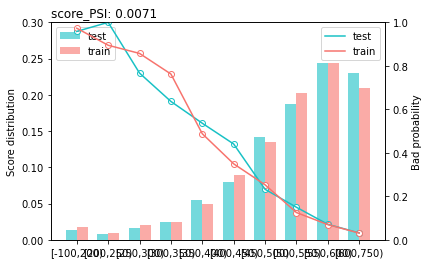

{'psi':   variable       PSI
 0    score  0.007064,
 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [40]:
#calclating the PSI index 
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

**Since value of PSI is less than 0.1, there is no significant change in the population measured, thus there is no need retrain the model with more recent data as of now.**

## Tuning Credit Scorecard Model

**Retrain the Logistic Regression model after performing resampling (oversampling on the minority class) using the Synthetic Minority Oversampling Technique(SMOTE) technique on the training dataset to fix the issue of imbalanced classification and model overfitting**

In [41]:
#https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
#https://stackoverflow.com/questions/66364406/attributeerror-smote-object-has-no-attribute-fit-sample
# oversample the minority class.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = train.columns

In [42]:
#After resampling using the SMOTE technique, occurrence of default and non-default events are of similar ratio
oversampled_trainY.value_counts(normalize = True)

1    0.5
0    0.5
Name: BAD, dtype: float64

C:\Users\acer\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\Users\acer\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


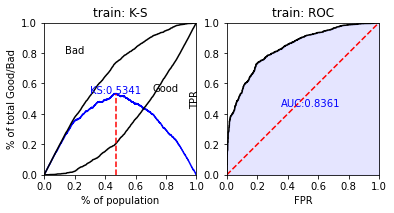

C:\Users\acer\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\Users\acer\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


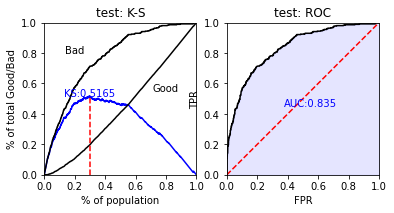

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1250
           1       0.71      0.47      0.57       538

    accuracy                           0.78      1788
   macro avg       0.76      0.69      0.71      1788
weighted avg       0.77      0.78      0.77      1788

[[1147  103]
 [ 284  254]]


In [43]:
#create a logistic regression model object
lr = LogisticRegression()
lr.fit(oversampled_trainX, oversampled_trainY)
# print(lr.coef_)
# print(lr.intercept_)

# Evaluate the performance of the Logistic Regression
train_pred = lr.predict_proba(oversampled_trainX)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(oversampled_trainY, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# Generate model predictions on test data. Print Evaluation metrics of the model
y_pred = lr.predict(X_test)

print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

**Model performance with the use of the resampling technique**

The AUC-ROC and K-S score did not change much.The precision score and f1-score for predicting default events has improved greatly.Even though the overall accuracy score and the weighted average for precision, recall and f1-score have dropped, the overall model performance is still reasonably good.  



**Regenerate scorecard (after resampling technique is applied) with base points adjusted to 0**

{'CLAGE':    variable            bin  points
42    CLAGE        missing    21.0
43    CLAGE    [-inf,70.0)   -24.0
44    CLAGE   [70.0,150.0)    19.0
45    CLAGE  [150.0,170.0)    43.0
46    CLAGE  [170.0,240.0)    65.0
47    CLAGE    [240.0,inf)   102.0,
 'CLNO':    variable          bin  points
33     CLNO      missing    27.0
34     CLNO  [-inf,10.0)    -1.0
35     CLNO  [10.0,24.0)    53.0
36     CLNO  [24.0,27.0)    79.0
37     CLNO  [27.0,39.0)    37.0
38     CLNO   [39.0,inf)    15.0,
 'DELINQ':   variable         bin  points
0   DELINQ     missing    87.0
1   DELINQ  [-inf,1.0)    76.0
2   DELINQ   [1.0,2.0)   -12.0
3   DELINQ   [2.0,inf)   -85.0,
 'DEROG':    variable         bin  points
39    DEROG     missing    70.0
40    DEROG  [-inf,1.0)    54.0
41    DEROG   [1.0,inf)   -17.0,
 'JOB':    variable           bin  points
22      JOB       missing   129.0
23      JOB        Office    85.0
24      JOB       ProfExe    62.0
25      JOB   Other%,%Mgr    27.0
26      JOB  Self%,

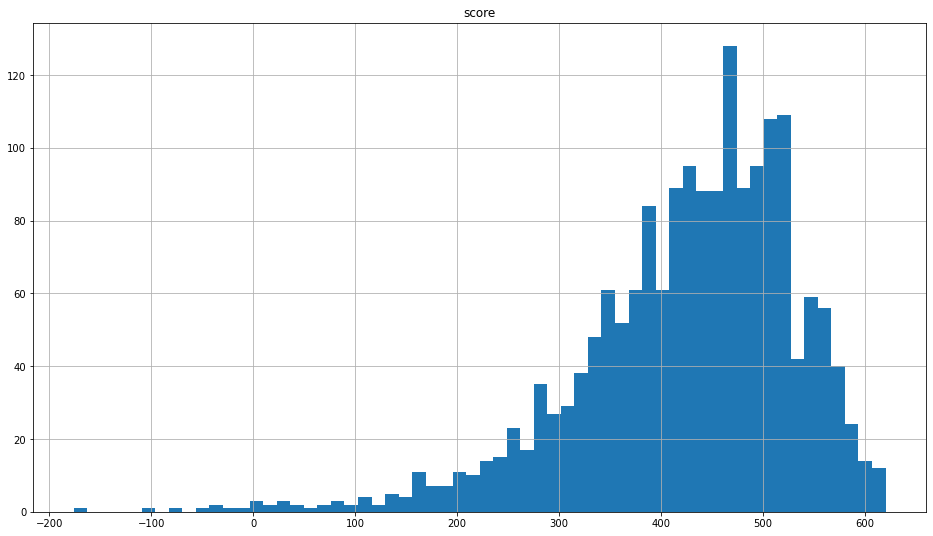

In [44]:
card2 = sc.scorecard(bins2, lr, X_train.columns, basepoints_eq0= True)

# credit score for samples in test and train
train_score2 = sc.scorecard_ply(oversampled_train, card2)
test_score2 = sc.scorecard_ply(test, card2)
#distribution of scores on test data
test_score2.hist(figsize=(16,9),bins=60)

pprint.pprint(card2)